In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [2]:
import env 
import acquire
import prepare
import model

### Aquire
Bringing the data from the MySQL DB

In [ ]:
raw_df = acquire.get_telco_chunk()

Data is a table of customer info. 

Most variables are categories about the customer's demographics and their services acquired.

Only continous variables are the tenure, monthly and total charges

In [ ]:
raw_df.info()

### Prepare
Converting the 'object' categories into Label-Encoded categories

In [5]:
df = prepare.prep_telco()

Prepare module gets rid of nulls and makes columns conform to Pandas friendly dtypes

In [6]:
# # Use a label encoder to transform the embarked column.
def encode_variable(column, df):
    lab_enc = LabelEncoder()
    lab_enc.fit(df[column])
    df[column] = lab_enc.transform(df[column])

In [7]:
cat_cols = df.select_dtypes('object').columns
for i in cat_cols:
    encode_variable(i, df)

All categorical variables are now in a numerical encoding for each category

In [ ]:
# df.info()
df.head()

#### MVP will use all the features in X

In [8]:
X = df.drop('churn',axis=1)
y = df['churn']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=123)

In [ ]:
X_train.head()

### Explore

## Please see the side questions at the end of this notebook for a focused exploration based on given questions regarding customer data

### Model

In [ ]:
y_pred, y_pred_proba = model.do_the_decisionTree('gini', X_train, y_train)

In [ ]:
print(metrics.classification_report(y_train, y_pred))

The accuracy is .783, which is just .04 better than if we predicted every customer would churn.

This model is better at finding customers that will remain than ones that will churn. It would be more helpful
to have better results in finding the likely-to-churn customers.

In [ ]:
decision_tree_conf_matrix = metrics.confusion_matrix(y_train, y_pred)
sns.heatmap(decision_tree_conf_matrix, annot=True,  fmt='');

We can see several False-Negatives, meaning there were several we did not predict to churn that did.

# Improved Viable Product
### Feature Selection

Beyond using some sort of feature selection technique, a max_depth has been set to one that improves accuracy yet does not overfit to the training data.

In [10]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [11]:
clf.score(X_train, y_train)

0.8219066937119676

In [12]:
clf.score(X_test, y_test)

0.7927117841930904

Scores improved using all the featues, but increasing the depth of the decision tree.

Using the feature importance attribute derived from the fitted Decision Tree classifier, the best features to use are listed.

In [13]:
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)

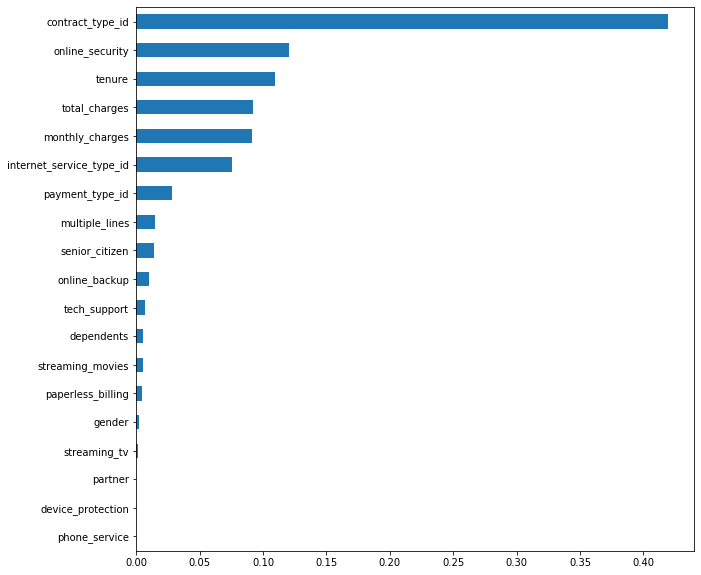

In [14]:
feat_importances.sort_values(ascending=True).plot(kind='barh' , figsize=(10,10)) 

### Create Feature Matrix with just the important features
DF is the name of the prepared dataframe

In [15]:
feat_importances.sort_values(ascending=False)[:5]

contract_type_id    0.419166
online_security     0.120401
tenure              0.109544
total_charges       0.091740
monthly_charges     0.091527
dtype: float64

In [16]:
important_feats = list(feat_importances.sort_values(ascending=False).index[:5])

In [17]:
X = df[important_feats]
y = df['churn']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=123)

In [19]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [20]:
clf.score(X_train, y_train)

0.813184584178499

In [21]:
clf.score(X_test, y_test)

0.7827733080927591

In [22]:
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

In [23]:
# FIX THIS IN THE MORNING. MAKE A CSV of Customer_id, Y_pred and Y_pred_proba[1]

4930

In [ ]:
print(metrics.classification_report(y_train, y_pred))

### Decision Tree has lower accuracy, but has less False Negatives. I find it to be a fair traide.

In [ ]:
decision_tree_conf_matrix = metrics.confusion_matrix(y_train, y_pred)
sns.heatmap(decision_tree_conf_matrix, annot=True,  fmt='');
title = 'Decision Tree'
plt.title(title);

In [ ]:
y_pred_test = clf.predict(X_test)

In [ ]:
decision_tree_conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
sns.heatmap(decision_tree_conf_matrix, annot=True,  fmt='');

In [ ]:
print(metrics.classification_report(y_test, y_pred_test))

# SIDE QUESTIONS

#### Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point?

In [ ]:
raw_df['price_groups'] = pd.cut(raw_df['monthly_charges'], 12)

In [ ]:
raw_df.groupby(["price_groups", "churn"]).size().unstack().plot(kind='bar', stacked=True) 

There looks to be a increase in the churn rate once monthly charges reach ~$68.50.

#### If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [ ]:
#These two new dataframes are each the customer tenure cohort of 12-months, divided by their contract types.
monthly_df = acquire.get_month2month()
annual_df = acquire.get_1year()

In [ ]:
#Retention rate for monthly subscribers after 12 months
(monthly_df['churn'] == 'No').sum()/len(monthly_df)

In [ ]:
#Retention rate for annual subscribers after 12 months
(annual_df['churn'] == 'No').sum()/len(annual_df)

The retention rate is higher for annual subscribers than monthly subscibers.

The annual retention rate is about the same as the rate for all customers. The monthly retention rate is lower.

In [ ]:
both = pd.concat([monthly_df, annual_df])

In [ ]:
ax = sns.countplot(x='contract_type_id', data=both, hue='churn', palette="Blues")
ax.set_title("Snapshot of 1-Year Customers")
plt.xlabel("Contract Type")

#### Controlling for services packages, is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? 

In [ ]:
df.monthly_charges.mean()

In [ ]:
churners = df[df['churn'] == 1]
remainers = df[df['churn'] == 0]

In [ ]:
churn_distro = churners.monthly_charges

In [ ]:
remain_distro = remainers.monthly_charges

In [ ]:
stats.ttest_ind(churn_distro, remain_distro)

The P-value is well below 0.05, so the null hypothesis- that the means between churners and non-churners is the same- can be rejected.

#### How much of monthly_charges can be explained by internet_service_type?

#### State your hypotheses and your conclusion clearly.

H0: The avearge monthly charges between internet service types are roughly the same.

HA: The average monthly charges are significantly different.

In [30]:
corr, p_value = stats.pearsonr(df.monthly_charges, df.internet_service_type_id)
print(f"Correlation = {corr}")
print(f"P_value = {p_value}")

Correlation = -0.3232601923373477
P_value = 5.245673672079001e-171


p_value is low, so the null hypothesis 

#### How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines). 

#### State your hypotheses and your conclusion clearly.

H0: The avearge monthly charges between internet service types and phone service are roughly the same.

HA: The average monthly charges are significantly different.